In [1]:
from tensorflow.python import keras
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import os
import scipy.io
import numpy as np 
import matplotlib.pyplot as plt


os.environ['KMP_DUPLICATE_LIB_OK']='True'
datax = scipy.io.loadmat("xtrain_hati20.mat")
z_true = scipy.io.loadmat("trj_hati.mat")
trj_data = z_true["xxhati"]
spike_data = datax["yy"]
obs_shape = 2

lr = 0.02

c = input_ = keras.layers.Input(shape=obs_shape)
c = keras.layers.Dense(300, activation="relu")(c)
c = keras.layers.Dense(300, activation="relu")(c)
critic_layer = keras.layers.Dense(1, activation="linear")(c)

model = keras.Model(input_, critic_layer)
optim = tf.keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optim)
model.summary()
loss_his = []
def train(model, experiences, episode):

    gamma = 0.9 

    if experiences[-1]["done"]:
        G = 0
    else:
        n_state = np.atleast_2d(experiences[-1]["n_state"])
        n_v = model(n_state)
        G = n_v[0][0].numpy()

    discounted_rewards = []
    for exp in reversed(experiences):
        if exp["done"]:
            G = 0
        G = exp["reward"] + gamma * G
        discounted_rewards.append(G)
    discounted_rewards.reverse()

    discounted_rewards = np.asarray(discounted_rewards).reshape((-1, 1))

    discounted_rewards -= np.mean(discounted_rewards)  

    state_batch = np.asarray([e["state"] for e in experiences])
    #print(experiences)
    with tf.GradientTape() as tape:
        v = model(state_batch, training=True)
        #print("V",v)
        #print("r",discounted_rewards)
        #print("v-r",(discounted_rewards - v) ** 2)
        loss = tf.reduce_mean((discounted_rewards - v) ** 2, axis=1, keepdims=True)
        #print("l",loss[:6])
        loss = tf.reduce_mean(loss)
    loss_his.append(loss)
        #print("loss",loss)
    #if episode % 50 == 0:
        #print("loss",loss)
    #if episode > 300: optim.lr =0.001
    gradients = tape.gradient(loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 300)               900       
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 301       
Total params: 91,501
Trainable params: 91,501
Non-trainable params: 0
_________________________________________________________________


In [2]:
batch_size = 500
num_inputs = 2 
experiences = []
state = np.zeros(num_inputs)
n_state = np.zeros(num_inputs)
for episode in range(100):
    if episode % 100 == 0:
        print("E",episode)
    state[0] = trj_data[0,0]
    state[1] = trj_data[0,1]
    done = False
    total_reward = 0

    for t in range(1,500):

        n_state[0] = trj_data[t,0]
        n_state[1] = trj_data[t,1]
        if n_state[1] < -3 and n_state[0]>3:# > 0 and n_state[1] > 0:
            reward = 1
            #print("R")
        else:
            reward = 0.1
            #print("N")
        if t == 500:
            done == True
        n_state = np.copy(n_state)
        total_reward += reward
        #print(state)
        experiences.append({
            "state": state,
            "reward": reward,
            "n_state": n_state,
            "done": done,
        })

        state = n_state

        if len(experiences) == batch_size:
            #print(experiences)
            train(model, experiences, episode)
            experiences = []

E 0


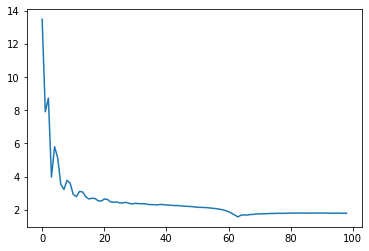

In [3]:
plt.plot(loss_his)

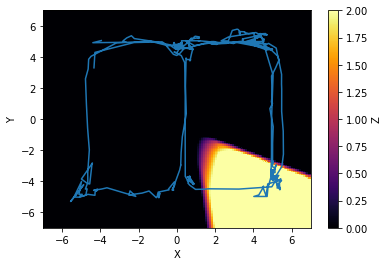

In [4]:
X, Y = np.mgrid[0:14.1:0.1, 0:14.1:0.1]
X-=7.0
Y-=7.0
z=np.zeros([140,140])
s = np.zeros(num_inputs)
for i in range(140):
    for j in range(140):
        s[0] = -7+ i/10
        s[1] = j/10-7
        z[i,j] = model(np.atleast_2d(s), training=False)[0]

fig, ax = plt.subplots()
im = ax.pcolormesh(X, Y, z, cmap='inferno',vmin=0,vmax=2)
ax.set_xlabel("X")
ax.set_ylabel("Y")
cbar = fig.colorbar(im)
cbar.set_label("Z")
plt.plot(trj_data[:,0],trj_data[:,1])
plt.show()